In [1]:
import os
import re
import glob
import json
import subprocess
import soundfile as sf
import argparse

import pandas as pd
import numpy as np
import librosa
import scipy.io.wavfile
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

main_dir = r"Datasets\TIMIT-dataset\data"

E:\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Preprocessing

In [2]:
# wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
#     if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
# frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
# print("Max frames:", np.max(frames))

# plt.figure(figsize=(10,4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Clip non-verbal units

In [3]:
def Clip(wav_paths, clip_buffer=320):
    for wav_path in tqdm(wav_paths, desc='Clip'):
        phn_path = wav_path.replace(".wav", ".phn")
        lines = open(phn_path, "r").readlines()
        y = librosa.load(wav_path, sr=16000)[0]
        y_1 = len(y)

        # First line
        start, end, phoneme = lines[0].split()
        if phoneme == "h#":
            if int(end) > clip_buffer:
                clip_factor = int(end) - clip_buffer
                y = y[clip_factor::]
                for i, line in enumerate(lines):
                    start, end, phoneme = line.split()
                    start = int(start) - clip_factor
                    end = int(end) - clip_factor
                    lines[i] = f"{max(0, start)} {end} {phoneme}\n"

        # Middle lines
        phonemes = np.array([line.split()[-1] for line in lines])
        cond = (phonemes == "pau") | (phonemes == "sil") | (phonemes == "epi")
        for i in np.where(cond)[0]:
            start, end, phoneme = lines[i].split()
            start, end = int(start), int(end)
            delta = end - start
            clip_factor = delta - clip_buffer
            if delta >= clip_buffer:
                new_end = int(end) - clip_factor
                lines[i] = f"{start} {new_end} {phoneme}\n"
                y = np.concatenate((y[:new_end], y[end:]), axis=0)
                for j in range(i+1, len(lines)):
                    start, end, phoneme = lines[j].split()
                    start = int(start) - clip_factor
                    end = int(end) - clip_factor
                    lines[j] = f"{start} {end} {phoneme}\n"

        # Last line
        start, end, phoneme = lines[-1].split()
        if phoneme == "h#":
            delta = int(end) - int(start)
            if delta > clip_buffer:
                end = int(start) + clip_buffer
                lines[-1] = f"{start} {end} {phoneme}\n"
                y = y[:end]
    
        with open(phn_path, "w") as f:
            f.writelines(lines)

        sf.write(wav_path, y, 16000)    

# Clip(wav_paths)

In [4]:
# wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
#     if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
# frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
# print("Max frames:", np.max(frames))

# plt.figure(figsize=(10,4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Split

In [5]:
def Split(wav_paths):
    cutoff_limit = 60000
    split_files, frames = [], []
    for wav_path in tqdm(wav_paths, desc='Split'):
        y = librosa.load(wav_path, sr=16000)[0]
        n_frames = len(y)
        frames.append(n_frames)
        if n_frames >= cutoff_limit:
            phn_path = wav_path.replace("wav", "phn")
            lines = open(phn_path, "r").readlines()
            end = np.array([int(line.split()[1]) for line in lines])
            mid_point = n_frames // 2
            idx = np.where(end <= mid_point)[0][-1]
            lines_1 = lines[:idx]
            lines_2 = lines[idx:]
            factor = int(lines_2[0].split()[0])
            for i, line in enumerate(lines_2):
                start, end, phoneme = line.split()
                start = int(start) - factor
                end = int(end) - factor
                line = " ".join([str(start), str(end), phoneme + "\n"])
                lines_2[i] = line
            f1_path = os.path.splitext(phn_path)[0] + "_1.phn"
            f2_path = os.path.splitext(phn_path)[0] + "_2.phn"
            if (len(y[:factor]) > cutoff_limit) | (len(y[factor:]) > cutoff_limit):
                print(lines_1, lines_2)
            for path, lines in zip([f1_path, f2_path], [lines_1, lines_2]):
                with open(path, "w") as f:
                    f.writelines(lines)    
            sf.write(f1_path.replace("phn", "wav"), y[:factor], 16000)
            sf.write(f2_path.replace("phn", "wav"), y[factor:], 16000)
            split_files.append(wav_path)

    print("Number of splitted files:", len(split_files))
    return split_files

# split_files = Split(wav_paths)

In [6]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths if not path in split_files]
# frames = []
# for wav_path in wav_paths:
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     frames.append(n_frames)

# pd.DataFrame({'wav_paths': wav_paths}).to_csv("Datasets\TIMIT-dataset\data.csv", index=False)

# print("Number of files:", len(wav_paths))
# print("Max frames:", np.max(frames))
# plt.figure(figsize=(10, 4))
# sns.histplot(data=frames)
# plt.axvline(x=np.mean(frames), color='red')
# plt.xlabel("Number of frames per sample")
# plt.show()

## Padding

In [7]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths if not path in split_files]
    
# for wav_path in tqdm(wav_paths, desc='Padding'):
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     y_sil = np.array([])
#     if n_frames != cutoff_limit:
#         pad_length = cutoff_limit - n_frames

#         with open(wav_path.replace("wav", "phn"), "r") as f:
#             lines = f.readlines()
#         phonemes = np.array([line.split()[-1] for line in lines])
#         for i in np.where(phonemes == "h#")[0]:
#             start_sil, end_sil = list(map(int, lines[i].split()[:-1]))
#             y_sil = np.concatenate([y_sil, y[start_sil:end_sil]])
        
#         if len(y_sil) >= pad_length:
#             y_sil = y_sil[:pad_length]
#         else:
#             extension = pad_length - len(y_sil)
#             y_sil = np.pad(y_sil, (0, extension), mode='wrap')
        
#         np.random.shuffle(y_sil)
#         y = np.concatenate([y, y_sil])
        
#         start, end, phoneme = lines.pop(-1).split()
#         if lines[-1].split()[-1] == "h#":
#             line = " ".join([end, str(cutoff_limit), phoneme])
#         else:
#             line = " ".join([start, str(cutoff_limit), "h#\n"])
#         lines.append(line)

#         with open(wav_path.replace("wav", "phn"), "w") as f:
#             f.writelines(lines)

#         sf.write(wav_path, y, 16000)

#     else:
#         pass

In [8]:
d = pd.read_csv("Datasets\TIMIT-dataset\data.csv")
d = d.sample(len(d)-2, random_state=42)
d

,wav_paths
6025,Datasets\TIMIT-dataset\data\DR7\MDVC0\SX216.wav
4367,Datasets\TIMIT-dataset\data\DR5\MCMB0\SX98.wav
6494,Datasets\TIMIT-dataset\data\DR7\MTKD0\SI630_1.wav
3947,Datasets\TIMIT-dataset\data\DR5\FDMY0\SA1_1.wav
5982,Datasets\TIMIT-dataset\data\DR7\MDLM0\SX424.wav
...,...
5734,Datasets\TIMIT-dataset\data\DR7\FPAC0\SI661_2.wav
3092,Datasets\TIMIT-dataset\data\DR4\FSEM0\SX298.wav
3772,Datasets\TIMIT-dataset\data\DR4\MSMC0\SI647.wav
5191,Datasets\TIMIT-dataset\data\DR6\MAJP0\SX174.wav


# TFrecords

## Write

In [9]:
def ArgParser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--n_splits", dest="n_splits", type=int, default=5)
    parser.add_argument("--n_samples", dest="n_samples", type=int, default=6950)
    parser.add_argument("--n_classes", dest="n_classes", type=int, default=61)
    parser.add_argument("--sample_rate", dest="sample_rate", type=int, default=16000)
    parser.add_argument("--n_fft", dest="n_fft", type=int, default=2048)
    parser.add_argument("--window_size", dest="window_size", type=int, default=400)
    parser.add_argument("--hop_length", dest="hop_length", type=int, default=160) # 160 samples = 10ms
    parser.add_argument("--n_mels", dest="n_mels", type=int, default=64)
    parser.add_argument("--n_mfcc", dest="n_mfcc", type=int, default=13)
    parser.add_argument("--batch_size", dest="batch_size", type=int, default=32)
    parser.add_argument("--buffer_size", dest="buffer_size", type=int, default=1024)
    parser.add_argument("--max_samples", dest="max_samples", type=int, default=60000)
    parser.add_argument("--delta_width", dest="delta_width", type=int, default=3)
    parser.add_argument("--learning_rate", dest="learning_rate", type=float, default=1e-3)
    parser.add_argument("--epochs", dest="epochs", type=int, default=50)
    parser.add_argument("--dropout", dest="dropout", type=float, default=0.1)
    parser.add_argument("--type", dest="type", type=str, default="mfcc")
    parser.add_argument("--main_dir", dest='main_dir', type=str, default="Datasets/TIMIT-dataset/tfrec_data")
    
    args = parser.parse_known_args()[0]
    test_size = (1 / args.n_splits)
    seq_len = int(np.ceil(args.max_samples / args.hop_length))
    if args.type == "mel":
        input_shape = (seq_len, args.n_mels)
    else:
        input_shape = (seq_len, args.n_mfcc*3)
    n_train = int(args.n_samples * (1 - test_size))
    train_steps = int(np.ceil(n_train / args.batch_size))
    parser.add_argument("--test_size", type=float, default=test_size)
    parser.add_argument("--input_shape", type=tuple, default=input_shape)
    parser.add_argument("--seq_len", type=int, default=seq_len)
    parser.add_argument("--train_steps", type=int, default=train_steps)
    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(batch_size=32, buffer_size=1024, delta_width=3, dropout=0.1, epochs=50, hop_length=160, input_shape=(375, 39), learning_rate=0.001, main_dir='Datasets/TIMIT-dataset/tfrec_data', max_samples=60000, n_classes=61, n_fft=2048, n_mels=64, n_mfcc=13, n_samples=6950, n_splits=5, sample_rate=16000, seq_len=375, test_size=0.2, train_steps=174, type='mfcc', window_size=400)

In [10]:
class TFRWriter():
    def __init__(self, args):
        self.samples = d['wav_paths'].tolist()
        self.args = args
        self.dict_path = "Datasets\TIMIT-dataset\phoneme_dict.json"
        self.phoneme_dict = self.get_dict()

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'binary_labels': self._bytes_feature(args[1]),
            'framewise_labels': self._bytes_feature(args[2]),
            'attention_mask': self._bytes_feature(args[3]),
            'true_length': self._int64_feature(args[4]),
            'filename': self._bytes_feature(args[5])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_binary_labels(self, p_frames): # Original
        p_frames = tf.convert_to_tensor(p_frames)
        labels = tf.tensor_scatter_nd_update(
            tensor=tf.zeros([p_frames[-1]+1], dtype=tf.int32), 
            indices=tf.expand_dims(p_frames[1:], axis=1), 
            updates=tf.ones([p_frames.shape[0]-1], dtype=tf.int32))
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        labels = tf.concat([labels, padding], axis=0)
        labels = tf.cast(labels, dtype=tf.float32)
        return labels        

    def get_framewise_labels(self, p_frames, phonemes):
        labels = []
        for i in range(1, len(p_frames)):
            for j in range(p_frames[i-1], p_frames[i]):
                labels.append(phonemes[i-1])
        labels = tf.convert_to_tensor(labels)
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        labels = tf.concat([labels, padding], axis=0)
        labels = tf.one_hot(labels, depth=self.n_classes, dtype=tf.int32)
        return labels

    def get_attention_mask(self, p_frames):
        mask = tf.convert_to_tensor(
            [True if i < p_frames[-1] else False for i in range(self.args.seq_len)])
        return mask

    def get_shards(self):
        speaker_id = [sample.split('\\')[4] for sample in self.samples]
        skf = StratifiedKFold(
            n_splits=self.args.n_splits, shuffle=True, random_state=42)
        return [
            list(map(lambda x: self.samples[x], j)) 
            for i, j in skf.split(self.samples, speaker_id)]

    def get_dict(self):
        phonemes = set()
        markers = ['h#', 'pau', 'epi']
        for sample in self.samples:
            base_path = os.path.splitext(sample)[0]
            with open(base_path + '.phn', "r") as f:
                for line in f.readlines():
                    phoneme = line.split()[-1]
                    if not phoneme in markers:
                        phonemes.add(phoneme)
        phonemes = markers + sorted(Counter(phonemes), key=Counter(phonemes).get, reverse=True)
        self.n_classes = len(phonemes)
        phonemes_dict = {v: i+1 for i, v in enumerate(phonemes)}
        with open(self.dict_path, "w") as f:
            json.dump(phonemes_dict, f, sort_keys=False, indent=4)
        return phonemes_dict 

    def get_audio(self, wav_path, feature_type):
        y, sr = librosa.load(wav_path, sr=self.args.sample_rate)
        y = librosa.util.fix_length(y, self.args.max_samples)
        if feature_type == "mfcc":
            mfcc = librosa.feature.mfcc(
                y=y, sr=sr, n_mfcc=self.args.n_mfcc, hop_length=self.args.hop_length,
                win_length=self.args.window_size, n_mels=self.args.n_mels,
                n_fft=self.args.n_fft, fmin=0, fmax=8000)[:, :self.args.seq_len]
            mfcc = np.transpose(mfcc)
            delta = librosa.feature.delta(
                mfcc, width=self.args.delta_width, order=1, axis=0)
            delta2 = librosa.feature.delta(
                mfcc, width=self.args.delta_width, order=2, axis=0)
            mfcc = np.concatenate((mfcc, delta, delta2), axis=-1)
            mfcc = minmax_scale(mfcc, axis=1)
            return mfcc
        else:
            mel_spectrogram = librosa.feature.melspectrogram(
                y=y, sr=sr, n_fft=self.args.n_fft, 
                hop_length=self.args.hop_length, win_length=self.args.window_size, 
                n_mels=self.args.n_mels, fmin=0, fmax=8000)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram = np.transpose(mel_spectrogram)[:self.args.seq_len, :]
            return mel_spectrogram
        
    def get_shard_data(self, samples, shard):
        for sample in tqdm(
                samples, total=len(samples), desc=f"Writing shard {shard}"):
            base_path = os.path.splitext(sample)[0]
            p_frames, phonemes = [0], []
            with open(base_path + ".phn") as f:
                for line in f.readlines():
                    p_frame, phoneme = line.split()[1::]
                    p_frames.append(int(p_frame) // self.args.hop_length)
                    phonemes.append(str(phoneme))
            phonemes = list(map(self.phoneme_dict.get, phonemes))
            binary_labels = self.get_binary_labels(p_frames)
            framewise_labels = self.get_framewise_labels(p_frames, phonemes)
            audio = self.get_audio(base_path + ".wav", self.args.type)
            spec_mask = self.get_attention_mask(p_frames)
            filename = str.encode("/".join(sample.split('\\')[-3::]))
            yield {
                "audio": tf.io.serialize_tensor(audio),
                "binary_labels": tf.io.serialize_tensor(binary_labels),
                "framewise_labels": tf.io.serialize_tensor(framewise_labels),
                "attention_mask": tf.io.serialize_tensor(spec_mask),
                "true_length": p_frames[-1],
                "filename": filename}

    def write(self):
        for shard, samples in enumerate(self.get_shards()):
            with tf.io.TFRecordWriter(
                    f"Datasets/TIMIT-dataset/tfrec_data/train_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples, shard+1):
                    example = self.serialize_example(
                        sample['audio'], sample['binary_labels'], 
                        sample['framewise_labels'], sample['attention_mask'],
                        sample['true_length'], sample['filename'])
                    f.write(example)

TFRWriter(args).write()

Writing shard 1:   0%|          | 0/1390 [00:00<?, ?it/s]

Writing shard 2:   0%|          | 0/1390 [00:00<?, ?it/s]

Writing shard 3:   0%|          | 0/1390 [00:00<?, ?it/s]

Writing shard 4:   0%|          | 0/1390 [00:00<?, ?it/s]

Writing shard 5:   0%|          | 0/1390 [00:00<?, ?it/s]

## Loading

In [11]:
class DataLoader():
    def __init__(self, args):
        self.files = [os.path.join(args.main_dir, f) for f in os.listdir(args.main_dir)]
        self.args = args
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True)
        self.train = self.train()
        self.val = self.val()

    def decode_audio(self, string):
        audio = tf.audio.decode_wav(string, desired_samples=self.args.max_samples)[0]
        return tf.squeeze(audio, axis=-1)

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'framewise_labels': tf.io.FixedLenFeature([], tf.string),
            'binary_labels': tf.io.FixedLenFeature([], tf.string),
            'attention_mask': tf.io.FixedLenFeature([], tf.string),
            'filename': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = tf.io.parse_tensor(
            example['audio'], out_type=tf.float32)
        example['binary_labels'] = tf.io.parse_tensor(
            example['binary_labels'], out_type=tf.float32)
        example['framewise_labels'] = tf.io.parse_tensor(
            example['framewise_labels'], out_type=tf.int32)
        example['attention_mask'] = tf.io.parse_tensor(
            example['attention_mask'], out_type=tf.bool)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset
 
    def SpecAugment(self, sample, training):
        audio = sample['audio']
        if training == True:
            audio = tfio.audio.freq_mask(audio, param=5)
            audio = tfio.audio.time_mask(audio, param=10)
        inputs = {"audio": audio, "mask": sample['attention_mask']}
        # outputs = {'labels': sample['binary_labels']}
        outputs = {'labels': sample['framewise_labels']}
        return inputs, outputs

    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=True), 
            num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=False), 
            num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

train = DataLoader(args).train
val = DataLoader(args).val
inputs, outputs = next(iter(train))
print("audio shape:", inputs['audio'].shape)
print("mask shape:", inputs['mask'].shape)
print("labels shape:", outputs['labels'].shape)

audio shape: (32, 375, 39)
mask shape: (32, 375)
labels shape: (32, 375, 61)


## SpecAugment

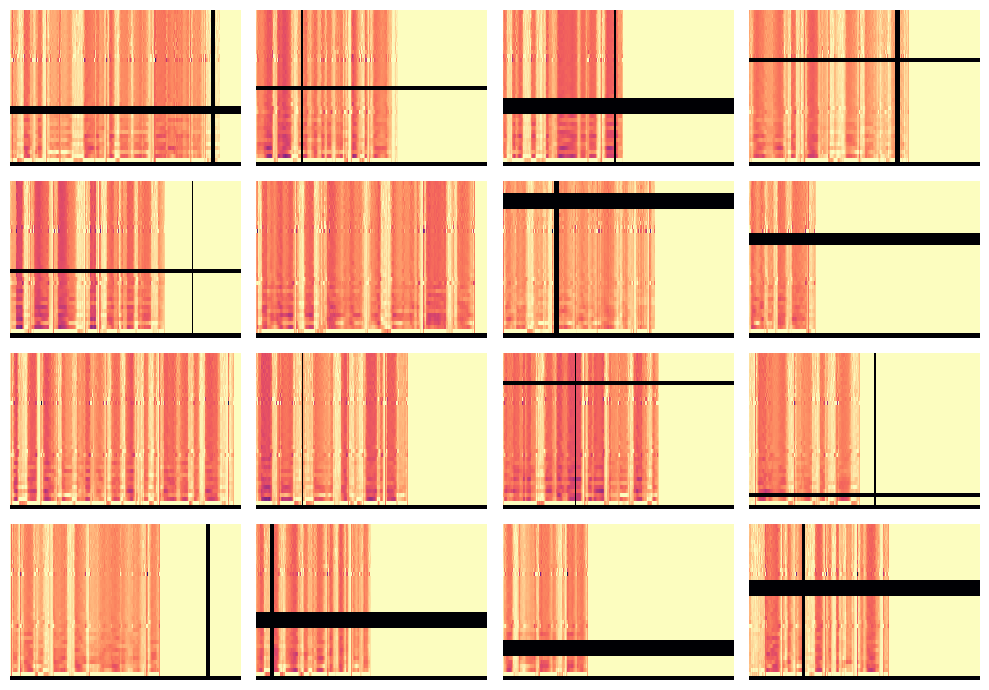

In [12]:
import librosa.display

train = train.unbatch().batch(16)
spectrogram = next(iter(train))[0]['audio']

plt.figure(figsize=(10, 7))
n_samples = spectrogram.shape[0]
row = 4; col = int(n_samples / 4)

for i in range(n_samples):
    plt.subplot(row, col, i+1)
    plt.axis("off")
    librosa.display.specshow(
        np.transpose(spectrogram[i].numpy()), 
        sr=args.sample_rate,
        hop_length=args.hop_length)

plt.tight_layout()
plt.show()

# Model

Model: "Segmentor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio (InputLayer)              [(None, 375, 39)]    0                                            
__________________________________________________________________________________________________
mask (InputLayer)               [(None, 375)]        0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 375, 400)     384000      audio[0][0]                      
                                                                 mask[0][0]                       
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 375, 200)     400800      bidirectional[0][0]      

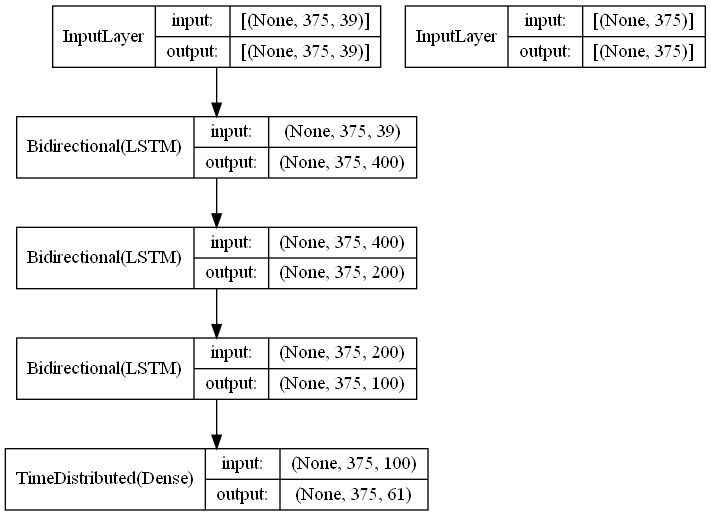

In [13]:
def Segmentor(args):
    spectrogram = Input(shape=args.input_shape, dtype=tf.float32, name='audio')
    mask = Input(shape=args.input_shape[0], dtype=tf.bool, name='mask')

    x = Bidirectional(LSTM(200, dropout=args.dropout, return_sequences=True))(spectrogram, mask=mask)
    x = Bidirectional(LSTM(100, dropout=args.dropout, return_sequences=True))(x, mask=mask)
    x = Bidirectional(LSTM(50, dropout=args.dropout, return_sequences=True))(x, mask=mask)
    x = TimeDistributed(Dense(61, activation='softmax'))(x, mask=mask)
    return Model(inputs=[spectrogram, mask], outputs=x, name='Segmentor')

model = Segmentor(args)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=False, show_dtype=False)

In [14]:
class SegmentorTrainer():
    def __init__(self, args):
        self.args = args
        self.model = Segmentor(args)
        self.dataloader = DataLoader(args)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
        self.metric = tfa.metrics.F1Score(num_classes=args.n_classes, average='micro')
    
    def train(self):
        for epoch in range(self.args.epochs):
            stateful_metrics = ['loss', 'f1', 'val_loss', 'val_f1']
            print(f"Epoch {epoch+1}/{self.args.epochs}")
            progbar = tf.keras.utils.Progbar(
                self.args.train_steps, interval=0.05,
                stateful_metrics=stateful_metrics)
            for step, (X_train, y_train) in enumerate(self.dataloader.train):
                t_mask = tf.cast(X_train['mask'], dtype=tf.float32)
                t_mask = tf.tile(tf.expand_dims(t_mask, axis=-1), [1,1,self.args.n_classes])
                labels = y_train['labels']
                with tf.GradientTape() as tape:
                    t_logits = model(X_train, training=True)
                    t_loss = self.loss_fn(labels, t_logits)
                grads = tape.gradient(t_loss, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                self.metric.update_state(labels, t_logits, sample_weight=t_mask)
                t_f1 = self.metric.result()
                progbar.update(
                    step, values=[('loss', t_loss), ('f1', t_f1)],
                    finalize=False)
                self.metric.reset_states()

            for X_val, y_val in self.dataloader.val:
                v_mask = tf.cast(X_val['mask'], dtype=tf.float32)
                v_mask = tf.tile(tf.expand_dims(v_mask, axis=-1), [1,1,self.args.n_classes])
                labels = y_val['labels']
                v_logits = model(X_val, training=False)
                v_loss = self.loss_fn(labels, v_logits)
                self.metric.update_state(labels, v_logits, sample_weight=v_mask)
            
            values = [
                ('loss', t_loss), ('f1', t_f1),
                ('val_loss', v_loss), ('val_f1', self.metric.result())]
            progbar.update(self.args.train_steps, values=values, finalize=True)
            self.metric.reset_states()
        return model

model = SegmentorTrainer(args).train()

Epoch 1/50
174/174 [==============================] - 47s 255ms/step - loss: 3.2740 - f1: 0.2717 - val_loss: 3.1824 - val_f1: 0.2896
Epoch 2/50
174/174 [==============================] - 45s 254ms/step - loss: 3.1278 - f1: 0.3082 - val_loss: 2.9029 - val_f1: 0.3547
Epoch 3/50
174/174 [==============================] - 44s 251ms/step - loss: 2.7911 - f1: 0.3311 - val_loss: 2.6625 - val_f1: 0.4060
Epoch 4/50
174/174 [==============================] - 44s 252ms/step - loss: 2.5191 - f1: 0.4281 - val_loss: 2.4388 - val_f1: 0.4365
Epoch 5/50
174/174 [==============================] - 45s 256ms/step - loss: 2.5259 - f1: 0.3747 - val_loss: 2.2910 - val_f1: 0.4591
Epoch 6/50
174/174 [==============================] - 45s 257ms/step - loss: 2.3277 - f1: 0.4039 - val_loss: 2.1519 - val_f1: 0.4821
Epoch 7/50
174/174 [==============================] - 46s 260ms/step - loss: 2.1075 - f1: 0.4167 - val_loss: 2.0211 - val_f1: 0.4963
Epoch 8/50
174/174 [==============================] - 46s 260ms/step 

In [15]:
y_pred = model.predict(val)[1]
y_true = next(iter(val))[1]['labels'][1]
tfa.metrics.F1Score(num_classes=args.n_classes, average='micro')(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.80266666>

In [16]:
tf.math.argmax(y_pred, axis=1)

<tf.Tensor: shape=(375,), dtype=int64, numpy=
array([ 1,  1, 28, 28, 28, 25, 25, 25, 25, 25, 25, 47, 47, 47, 47,  6,  6,
        6,  6,  6,  6,  6,  6,  6, 35, 35, 35, 16, 16, 16,  5, 52, 52, 52,
       17, 17, 17, 17, 17, 17, 54, 54, 54, 54, 54, 54, 54, 54, 54, 60, 12,
       57, 57, 57, 57, 57, 57,  9,  9,  9, 46, 46, 46, 46, 46, 46, 35, 35,
       35, 35, 35, 44, 44, 44, 44, 52, 52, 52, 52, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 35, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       56, 56, 56, 57, 57, 57, 57, 57, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 23, 23, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 37, 37,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       30, 30, 30, 30, 30, 30,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [17]:
tf.math.argmax(y_true, axis=1)

<tf.Tensor: shape=(375,), dtype=int64, numpy=
array([ 1,  1, 28, 28, 28, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,  6,  6,
        6,  6,  6,  6,  6,  6,  6, 16, 16, 16, 16, 16, 16, 16, 52, 52, 52,
       52, 17, 17, 17, 17, 17, 17, 54, 54, 54, 54, 54, 54, 54, 54, 60, 60,
       60, 60, 47, 47, 47, 47, 47, 47, 47, 47,  6,  6,  6,  6,  6,  6,  6,
       35, 35, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45,
       59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 56,
       56, 56, 56, 57, 57, 57, 57, 57, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       30, 30, 30, 30, 30,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,